In [69]:
import numpy as np
import cv2

from timeit import timeit

In [73]:
import matplotlib.pyplot as plt
%matplotlib inline

In [123]:
class PatchMatch:
    def __init__(self, target, source, patch_size=3, window_base_size=16, alpha=0.5):
        self.target_original = target
        self.source_original = source
        
        self.target_original_height, self.target_original_width = self.target_original.shape[:2]
        self.source_original_height, self.source_original_width = self.source_original.shape[:2]
        
        self.patch_size = patch_size
        self.margin = patch_size // 2
        self.window_base_size = window_base_size
        self.alpha = alpha
        self.random_search_levels = (-np.log(window_base_size)/np.log(alpha)).astype(np.int32)
        
        # extend images with mirror reflection, so that we have all patches complete further
        self.target = cv2.copyMakeBorder(target, self.margin, self.margin, self.margin, self.margin, cv2.BORDER_REFLECT_101)
        self.source = cv2.copyMakeBorder(source, self.margin, self.margin, self.margin, self.margin, cv2.BORDER_REFLECT_101)
        
        self.nnf = self.init_nearest_neighbor_field()
        self.dist = self.init_patch_distances()
        
    def init_nearest_neighbor_field(self):
        y_init = np.random.randint(0, self.source_original_height, size=(self.target_original_height, self.target_original_width))
        x_init = np.random.randint(0, self.source_original_width, size=(self.target_original_height, self.target_original_width))
        nnf_init = np.stack((y_init, x_init), axis=2)
        return nnf_init
    
    def init_patch_distances(self):
        return np.array([self.patch_distance(h, w, *self.nnf[h,w]) for h in range(self.target_original_height) for w in range(self.target_original_width)]).reshape(self.target_original_height, self.target_original_width)
    
    def patch_distance(self, target_patch_y, target_patch_x, source_patch_y, source_patch_x):
        target_patch = self.target[target_patch_y:target_patch_y+2*self.margin+1, target_patch_x:target_patch_x+2*self.margin+1]
        source_patch = self.source[source_patch_y:source_patch_y+2*self.margin+1, source_patch_x:source_patch_x+2*self.margin+1]
        D = (target_patch - source_patch).var()
        return D
    
    def propagate(self, h, w, forward_scan=True):
        if forward_scan:
            h_candidate = h-1
            w_candidate = w-1
        else:
            h_candidate = h+1
            w_candidate = w+1
            
        D_base = self.dist[h,w]
        D_candidate_row = self.dist[h, w_candidate]
        D_candidate_col = self.dist[h_candidate, w]
        
        if D_candidate_row < D_base and D_candidate_row < D_candidate_col:
            self.nnf[h,w] = self.nnf[h,w_candidate]
            self.dist[h,w] = self.patch_distance(h,w,*self.nnf[h,w_candidate])
        elif  D_candidate_col < D_base:
            self.nnf[h,w] = self.nnf[h_candidate,w]
            self.dist[h,w] = self.patch_distance(h,w,*self.nnf[h_candidate,w])
        # otherwise: no update
    
    def random_search(self, h, w):
        # TODO: implement
        for k in range(self.random_search_levels):
            # generate offset
            # add to h, w
            # clip
            # calc dist (?)
            # compare
        pass

    def iterate(self, iterations=3):
        odd_iteration = True
        h_start, h_end = 1, self.target_original_height
        w_start, w_end = 1, self.target_original_width
        step = 1
        
        for i in range(iterations):
            for h in range(h_start, h_end, step):
                for w in range(w_start, w_end, step): 
                    self.propagate(h, w, odd_iteration)
                    self.random_search(h, w) #TODO: implement 
            
            odd_iteration = not odd_iteration
            h_start, h_end = h_end-2*step, h_start-2*step
            w_start, w_end = w_end-2*step, w_start-2*step
            step = -step        
    
    def display_nnf(self):
        nnf = np.concatenate((self.nnf, np.zeros((self.target_original_height, self.target_original_width, 1))), axis=2)
        nnf[..., 0] = nnf[..., 0]/nnf[..., 0].max()
        nnf[..., 1] = nnf[..., 1]/nnf[..., 1].max()
        plt.imshow(nnf)

In [124]:
#%%timeit
b = PatchMatch(target, source, 3, 16, 0.5)

In [125]:
b.iterate()

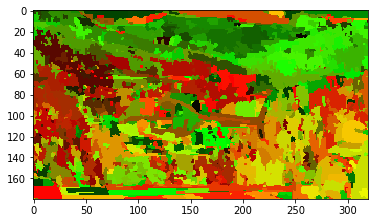

In [126]:
b.display_nnf()

In [75]:
source = cv2.imread('frames/v001.jpg')
target = cv2.imread('frames/v002.jpg')

In [76]:
source = cv2.resize(source, (320, 180))
target = cv2.resize(target, (320, 180))

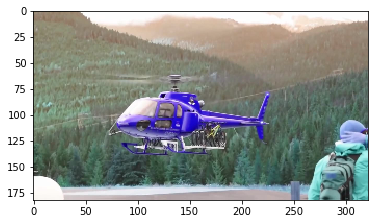

In [80]:
plt.imshow(b.target)

In [11]:
b.patch_distance(target, source)

13049.020669866693

In [ ]:
init

# util
patch_distance

# forward scan
propagate
random_search

# backward scan
propagate
random_search

In [ ]:
# params
patch_size 
window_size
alpha

In [30]:
def init(target, source):
    target_height, target_width = target.shape[:2]
    source_height, source_width = source.shape[:2]
    
    y_init = np.random.randint(0, source_height, size=(target_height, target_width))
    x_init = np.random.randint(0, source_width, size=(target_height, target_width))
    map_init = np.stack((y_init, x_init), axis=2)
    return map_init

In [32]:
map_init = init(target, source)

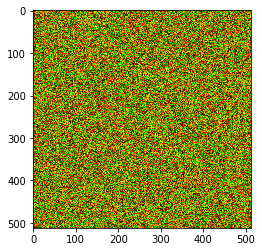

In [45]:
map_init2 = np.concatenate((map_init, np.zeros((map_init.shape[0], map_init.shape[1], 1))), axis=2)
map_init2[..., 0] = map_init2[..., 0]/map_init2[..., 0].max()
map_init2[..., 1] = map_init2[..., 1]/map_init2[..., 1].max()
plt.imshow(map_init2)

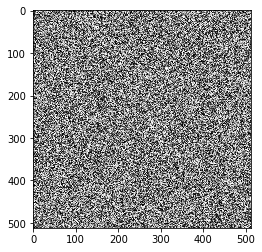

In [40]:
plt.imshow(map_init[..., 1], cmap='gray')